# Import Libraries

In [29]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

# Import Data from .csv

In [30]:
# specify year interval for training data
init_year = 2015
end_year = 2019 # inclusive

df_list = []
for year in range(init_year, end_year + 1):
    df = pd.read_csv(f'../data/Prepared data/{str(year)}_features.csv')
    df_list.append(df)

df_raw = pd.concat(df_list, axis=0, ignore_index=True)

# Add Day Type (weekday, weekend, holiday)

In [31]:
import datetime
import holidays

def is_workday(date:datetime.date):
    """
    Determines the type of day (workday or not) for a given date.

    Args:
        date (datetime.date): The date to check.

    Returns:
        int: 1 if workday else 0.
    """
    us_holidays = holidays.US()

    if date in us_holidays:
        return 0

    if date.weekday() >= 5:  # Saturday is 5, Sunday is 6
        return 0

    return 1


In [32]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np

class TimestampTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()

        X['timestamp'] = pd.to_datetime(X['timestamp'])
        X['is_workday'] = X['timestamp'].apply(lambda x: is_workday(x.date()))
        X['year'] = X['timestamp'].dt.year
        X['month'] = X['timestamp'].dt.month
        X['day'] = X['timestamp'].dt.day
        X['hour'] = X['timestamp'].dt.hour
        X['minute'] = X['timestamp'].dt.minute
        X = X.drop('timestamp', axis=1)
        return X

In [33]:
df = df_raw[['timestamp', 'load', 'temp']].copy()
df.to_csv('train_data.csv')
del df_raw

# Data Preprossing

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

timestamp_transformer = TimestampTransformer()
df = timestamp_transformer.transform(df)
imputer = SimpleImputer(strategy='mean')
df['load'] = imputer.fit_transform(df[['load']])
df['temp'] = imputer.fit_transform(df[['temp']])
scaler_temp = StandardScaler()
scaler_load = StandardScaler()
df['temp'] = scaler_temp.fit_transform(df[['temp']])
df['load'] = scaler_load.fit_transform(df[['load']])

# Make Dataset

In [7]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import Compose

class TimeSeriesDataset(Dataset):
    def __init__(self, df, seq_len, pred_len=1, transform=None, target_transform=None):
        """
        Custom Dataset for multivariate time series.

        Args:
            df (pd.Dataframe): Assume the dataframe has been preprocessed and has only numeriacal values.
            seq_length (int): Length of each sequence.
            transform: Composition of transformations.
        """
        super(TimeSeriesDataset, self).__init__()
        self.df = df
        self.features = self.df.values
        self.targets = self.df['load'].values
        self.seq_len = seq_len
        self.pred_len = pred_len
        
    def __len__(self):
        return len(self.features) - self.seq_len - self.pred_len + 1
    
    def __getitem__(self, idx):
        sequence = self.features[idx:idx + self.seq_len, :]
        sequence = torch.tensor(sequence, dtype=torch.float32)
        
        target = self.targets[idx + self.seq_len: idx + self.seq_len + self.pred_len]
        target = torch.tensor(target, dtype=torch.float32)
        
        return sequence, target

In [8]:
import numpy as np

dataset = TimeSeriesDataset(df, seq_len=288, pred_len=288)
train_size = int(0.8 * len(dataset))
train_dataset = torch.utils.data.Subset(dataset, range(train_size))
test_dataset = torch.utils.data.Subset(dataset, range(train_size, len(dataset)))

# Make Dataloader

In [9]:
from torch.utils.data import DataLoader

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, pin_memory=True)

# Model Implementation

In [10]:
import torch.nn as nn
import torch.nn.functional as F

import torch.nn as nn

class SimpleRNN(nn.Module):
    def __init__(self, num_features, output_size, hidden_size, num_layers, drop_rate=0):
        super(SimpleRNN, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.RNN(num_features, hidden_size, num_layers, batch_first=True, dropout=drop_rate, nonlinearity='relu')

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.rnn(x, h0.detach())
        out = out[:, -1, :]
        out = self.fc(out)

        return out

class SimpleLSTM(nn.Module):
    def __init__(self, num_features, output_size, hidden_size, num_layers, drop_rate=0):
        super(SimpleLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(num_features, hidden_size, num_layers, dropout=drop_rate, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, output_size)
    
    def _initialize_weights(self, num_features):
        # According to the paper, https://arxiv.org/pdf/1912.10454
        #   we want to preserve the variance through layers.
        # As a simplified approach:
        # - Set all biases to zero
        # - Initialize input-to-hidden weights with a variance ~ 1/N, where N is the number of features
        # - Initialize hidden-to-hidden weights orthogonally or with a small variance
        
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight_ih' in name:
                # Input to hidden weights: normal with std ~ 1/sqrt(num_features)
                nn.init.normal_(param, mean=0.0, std=(1.0 / np.sqrt(num_features)))
            elif 'weight_hh' in name:
                # Hidden to hidden weights: orthogonal initialization can help stability
                nn.init.orthogonal_(param)

        # For the fully connected layer
        nn.init.zeros_(self.fc.bias)
        # Xavier is a reasonable choice for the final layer
        nn.init.xavier_normal_(self.fc.weight)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        
        return out

class SimpleGRU(nn.Module):
    def __init__(self, num_features, output_size, hidden_size, num_layers, drop_rate=0):
        super(SimpleGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.gru = nn.GRU(num_features, hidden_size, num_layers, dropout=drop_rate, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.gru(x, h0)
        out = out[:, -1, :]
        out = self.fc(out)
        
        return out

# Training

In [11]:
from torch.amp import GradScaler, autocast
scaler = GradScaler()

In [12]:
import matplotlib.pyplot as plt

def evaluate_metrics(real_values, predictions): 
    ''' 
    Calculate evaluation metrics: MAE, MAPE, and R-squared. 

    Parameters 
    ---------- 

    real_values (array-like): The actual values. 
    predictions (array-like): The predicted values. 

    Returns 
    ------- 
    mae, mape, r_squared
    ''' 

    real_values = np.array(real_values) 
    predictions = np.array(predictions) 

    # Mean Absolute Error (MAE) 
    mae = np.mean(np.abs(real_values - predictions)) 

    # Mean Absolute Percentage Error (MAPE) 
    epsilon = 1e-6
    mape = np.mean(np.abs((real_values - predictions) / (real_values + epsilon))) * 100

    # R-squared 
    ss_res = np.sum((real_values - predictions) ** 2) 
    ss_tot = np.sum((real_values - np.mean(real_values)) ** 2) 
    r_squared = 1 - (ss_res / ss_tot)

    return mae, mape, r_squared

def model_evaluation(model, criterion, data_loader, device='cpu'):

    batch_losses = []

    model.eval() # switch to evalution mode
    with torch.no_grad():
        for inputs, labels in data_loader:

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            batch_losses.append(loss.item())

    model.train() # switch to training mode

    loss_mean = np.mean(batch_losses)

    return loss_mean

def training_loop(n_epochs, optimizer, model, criterion, train_loader, test_loader, verbose=False, scheduler=None, device='cpu', save_model=None, save_as='model.pt'):
    '''
    Set `verbose=True` to see scores for each epoch. If cuda is available, set `device='cuda'`.

    Return
    ------
    - train_losses (list): history of training loss
    - test_losses (list): history of test/validation loss
    '''
    train_losses = []
    test_losses = []

    min_test_loss = float('inf')
    for n in range(n_epochs):
        for x_batch, y_batch in train_loader:

            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad(set_to_none=True)
            with autocast(device_type='cuda', dtype=torch.float16):
                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        
        if scheduler != None:
            scheduler.step() # update learning rate
        
        train_loss = model_evaluation(model, criterion, train_loader, device=device)
        test_loss = model_evaluation(model, criterion, test_loader, device=device)

        # save model with lowest test/validation loss
        if test_loss < min_test_loss:
            min_test_loss = test_loss
            if save_model == 'best':
                torch.save(model.state_dict(), save_as)

        # save model at last epoch
        if save_model == 'last' and n == n_epochs - 1:
            torch.save(model.state_dict(), save_as)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        if ((n + 1) % 10 == 0) or verbose:
            print(f'Epoch {n + 1}/{n_epochs}: Training loss {train_loss:.4f}, Validation Loss {test_loss:.4f}')
            if scheduler != None:
                print(f"Current learning rate is {scheduler.get_last_lr()[0]}")
            print('----------------------------------------------------------')

    return train_losses, test_losses

def plot_metrics(train_metrics, test_metrics, metric_name):
    plt.figure(figsize=(8, 6))
    epochs = np.arange(len(train_metrics))

    plt.plot(epochs, train_metrics, label=f'Train {metric_name}', color='blue')
    plt.plot(epochs, test_metrics, label=f'Test {metric_name}', color='red')

    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [15]:
num_features = 8  # Number of features
output_size = 288
hidden_size = 32
num_layers = 2
num_epochs = 30
drop_rate = 0.3
lr_rate = 1e-4
weight_decay = 1e-4
scheduler = None

# rnn_model = SimpleRNN(num_features, output_size, hidden_size, num_layers, drop_rate=drop_rate).to('cuda')
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(rnn_model.parameters(), lr=lr_rate, weight_decay=weight_decay, fused=True)
# scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

# train_losses, val_losses = training_loop(
#     num_epochs, 
#     optimizer, 
#     rnn_model, 
#     criterion, 
#     train_loader, 
#     test_loader, 
#     verbose=True, 
#     scheduler=scheduler,
#     device='cuda', 
#     save_model='last', 
#     save_as='RNN.pt'
# )
# plot_metrics(train_losses, val_losses, 'Loss')

Epoch 1/30: Training loss 0.6312, Validation Loss 0.7075
Current learning rate is 0.0001
----------------------------------------------------------
Epoch 2/30: Training loss 0.2391, Validation Loss 0.2453
Current learning rate is 0.0001
----------------------------------------------------------
Epoch 3/30: Training loss 0.2204, Validation Loss 0.2148
Current learning rate is 0.0001
----------------------------------------------------------
Epoch 4/30: Training loss 0.1710, Validation Loss 0.1740
Current learning rate is 0.0001
----------------------------------------------------------
Epoch 5/30: Training loss 0.1552, Validation Loss 0.1690
Current learning rate is 0.0001
----------------------------------------------------------
Epoch 6/30: Training loss 0.1497, Validation Loss 0.1659
Current learning rate is 0.0001
----------------------------------------------------------
Epoch 7/30: Training loss 0.1536, Validation Loss 0.1640
Current learning rate is 0.0001
-----------------------

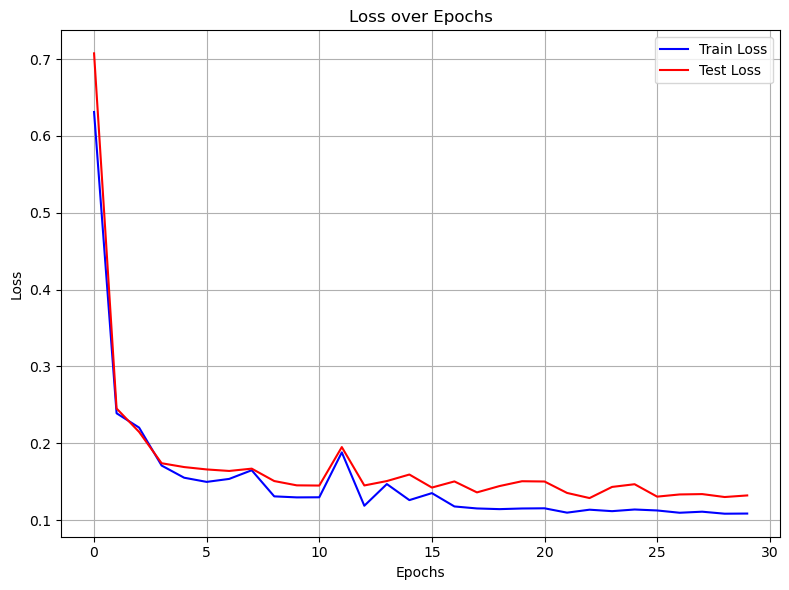

In [16]:
lstm_model = SimpleLSTM(num_features, output_size, hidden_size, num_layers, drop_rate=drop_rate).to('cuda')
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=lr_rate, weight_decay=weight_decay, fused=True)
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)

train_losses, val_losses = training_loop(
    num_epochs, 
    optimizer, 
    lstm_model, 
    criterion, 
    train_loader, 
    test_loader, 
    verbose=True, 
    scheduler=scheduler,
    device='cuda', 
    save_model='last', 
    save_as='LSTM.pt'
)
plot_metrics(train_losses, val_losses, 'Loss')

Epoch 1/30: Training loss 0.4756, Validation Loss 0.4020
Current learning rate is 0.0001
----------------------------------------------------------
Epoch 2/30: Training loss 0.2621, Validation Loss 0.2599
Current learning rate is 0.0001
----------------------------------------------------------
Epoch 3/30: Training loss 0.2496, Validation Loss 0.2557
Current learning rate is 0.0001
----------------------------------------------------------
Epoch 4/30: Training loss 0.1635, Validation Loss 0.1743
Current learning rate is 0.0001
----------------------------------------------------------
Epoch 5/30: Training loss 0.1480, Validation Loss 0.1597
Current learning rate is 0.0001
----------------------------------------------------------
Epoch 6/30: Training loss 0.1418, Validation Loss 0.1558
Current learning rate is 0.0001
----------------------------------------------------------
Epoch 7/30: Training loss 0.1486, Validation Loss 0.1658
Current learning rate is 0.0001
-----------------------

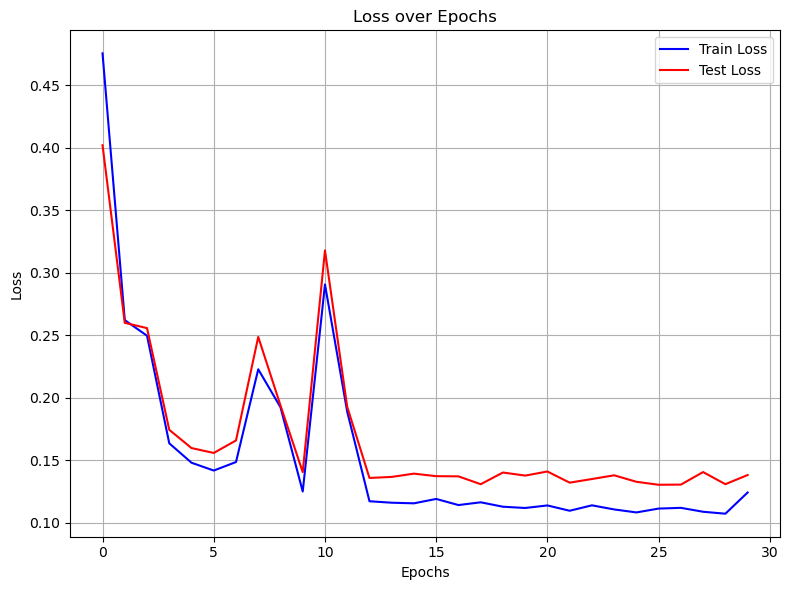

In [17]:
gru_model = SimpleGRU(num_features, output_size, hidden_size, num_layers).to('cuda')
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gru_model.parameters(), lr=lr_rate, weight_decay=weight_decay, fused=True)
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)

train_losses, val_losses = training_loop(
    num_epochs, 
    optimizer, 
    gru_model, 
    criterion, 
    train_loader, 
    test_loader, 
    verbose=True, 
    scheduler=scheduler,
    device='cuda', 
    save_model='last',
    save_as='GRU.pt'
)
plot_metrics(train_losses, val_losses, 'Loss')

# Make Predictions


In [34]:
# get 2020 data
df_2020_raw = pd.read_csv('../data/Prepared data/2020_features.csv')
df_2020 = df_2020_raw[['timestamp', 'load', 'temp']].copy()
del df_2020_raw
df_2020 = timestamp_transformer.transform(df_2020)
df_2020['load'] = imputer.fit_transform(df_2020[['load']])
df_2020['temp'] = scaler_temp.transform(df_2020[['temp']])
df_2020['load'] = scaler_load.transform(df_2020[['load']])
df_2020.to_csv('test_data.csv')

In [19]:
import torch
import numpy as np

def make_predictions(model, test_data, device='cuda'):
    """
    Evaluate the model on test_data for the year 2020 and produce 1D arrays of predictions and actuals.

    Parameters
    ----------
    model : torch.nn.Module
        The trained model that takes an input of shape [1, 288, 7] and outputs [1, 288].
    test_data : torch.Tensor
        A tensor of shape [N, 7] containing continuous test data for 2020.
        The columns are [load, temp, is_workday, year, month, day, hour].
        Assume test_data is normalized/processed the same way as the training data.
    device : str, optional
        Device to run computations on ('cuda' or 'cpu'), by default 'cuda'.

    Returns
    -------
    predictions : np.ndarray
        1D array containing the model's predicted load values for all predicted timesteps.
    actuals : np.ndarray
        1D array containing the actual load values for the corresponding timesteps.
    """

    model = model.to(device)
    model.eval()

    total_steps = test_data.shape[0]
    # Each prediction uses 288 steps as input and predicts the next 288 steps.
    # Need at least 288 steps beyond the input window for a full prediction.
    max_start = total_steps - 288 * 2
    if max_start < 0:
        raise ValueError("Not enough test data to form a single input-output pair.")

    all_predictions = []
    all_actuals = []

    with torch.no_grad():
        # Slide over test_data in increments of 288 steps (e.g., one day at a time, if 288 steps = one day)
        for start_idx in range(0, max_start + 1, 288):
            # Extract input sequence
            input_seq = test_data[start_idx : start_idx+288]  # [288, 7]
            input_seq = input_seq.unsqueeze(0).to(device)     # [1, 288, 7]

            # Run the model
            pred = model(input_seq)         # [1, 288]
            pred = pred.squeeze(0).cpu().numpy()  # [288]

            # Actual load for the next 288 steps
            target_seq = test_data[start_idx+288 : start_idx+576, 0].cpu().numpy()  # [288]

            # Collect results
            all_predictions.append(pred)
            all_actuals.append(target_seq)

    # Convert to arrays of shape [M, 288]
    all_predictions = np.array(all_predictions)  # [M, 288]
    all_actuals = np.array(all_actuals)          # [M, 288]

    # Flatten to 1D arrays
    predictions = all_predictions.flatten()  # 1D array
    actuals = all_actuals.flatten()          # 1D array

    return predictions, actuals


In [20]:
# Load saved models

# lstm_model = SimpleLSTM(num_features, output_size, hidden_size, num_layers).to('cuda')
# lstm_model.load_state_dict(torch.load('LSTM.pt', weights_only=True))
# lstm_model.eval()

# gru_model = SimpleGRU(num_features, output_size, hidden_size, num_layers).to('cuda')
# gru_model.load_state_dict(torch.load('GRU.pt', weights_only=True))
# gru_model.eval()

## Test on training dataset

In [21]:
# initial_np = df.iloc[:288].to_numpy(dtype=np.float32)
# initial_tensor = torch.tensor(initial_np, dtype=torch.float32)
test_np = df.iloc[:8*288].to_numpy(dtype=np.float32)
test_tensor = torch.tensor(test_np, dtype=torch.float32)

# predictions_rnn, actual = make_predictions(rnn_model, test_tensor, device='cuda')
predictions_lstm, actual = make_predictions(lstm_model, test_tensor, device='cuda')
predictions_gru, _ = make_predictions(gru_model, test_tensor, device='cuda')

LSTM: MAE 0.253243625164032, MAPE 87.79551386833191, R^2 0.8622545003890991
GRU: MAE 0.2824328541755676, MAPE 92.33360886573792, R^2 0.82203109562397


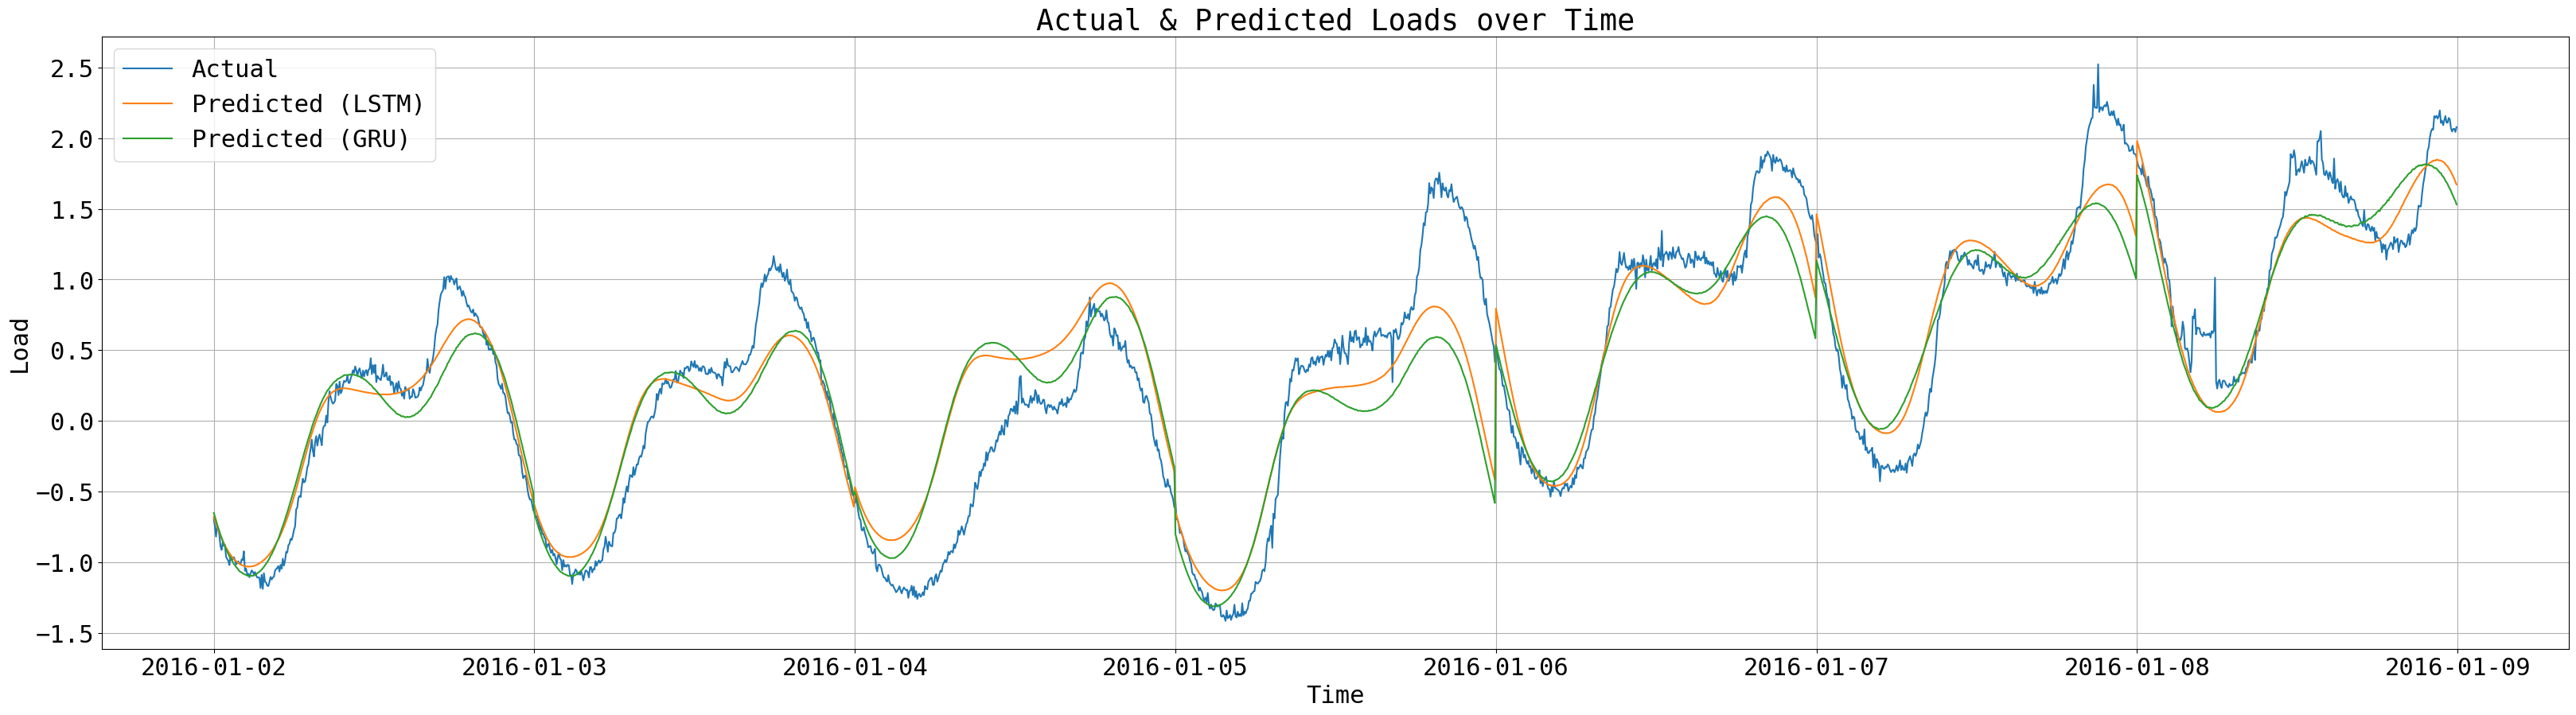

In [22]:
import matplotlib.pyplot as plt

# rnn_scores = evaluate_metrics(actual, predictions_rnn)
# print(f'RNN: MAE {rnn_scores[0]}, MAPE {rnn_scores[1]}, R^2 {rnn_scores[2]}')
lstm_scores = evaluate_metrics(actual, predictions_lstm)
print(f'LSTM: MAE {lstm_scores[0]}, MAPE {lstm_scores[1]}, R^2 {lstm_scores[2]}')
gru_scores = evaluate_metrics(actual, predictions_gru)
print(f'GRU: MAE {gru_scores[0]}, MAPE {gru_scores[1]}, R^2 {gru_scores[2]}')

font = {'family' : 'monospace',
        'weight' : 'normal',
        'size'   : 22}

plt.rc('font', **font)

time_interval = pd.date_range(start="2016-01-02", periods=len(actual), freq='5min')
plt.figure(figsize=(40,10))
plt.plot(time_interval, actual, label='Actual')
# plt.plot(time_interval, predictions_rnn, label='Predicted (RNN)')
plt.plot(time_interval, predictions_lstm, label='Predicted (LSTM)')
plt.plot(time_interval, predictions_gru, label='Predicted (GRU)')
plt.legend()
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Load')
plt.title('Actual & Predicted Loads over Time')
plt.show()

## Test on unseen data from 2020

In [ ]:
test_np = df_2020.to_numpy(dtype=np.float32)
test_tensor = torch.tensor(test_np, dtype=torch.float32)

# predictions_rnn, actual = make_predictions(rnn_model, test_tensor, device='cuda')
predictions_lstm, actual = make_predictions(lstm_model, test_tensor, device='cuda')
predictions_gru, _ = make_predictions(gru_model, test_tensor, device='cuda')

LSTM: MAE 0.2957673966884613, MAPE 305.9119701385498, R^2 0.8527758121490479
GRU: MAE 0.30142802000045776, MAPE 300.74005126953125, R^2 0.8485664576292038


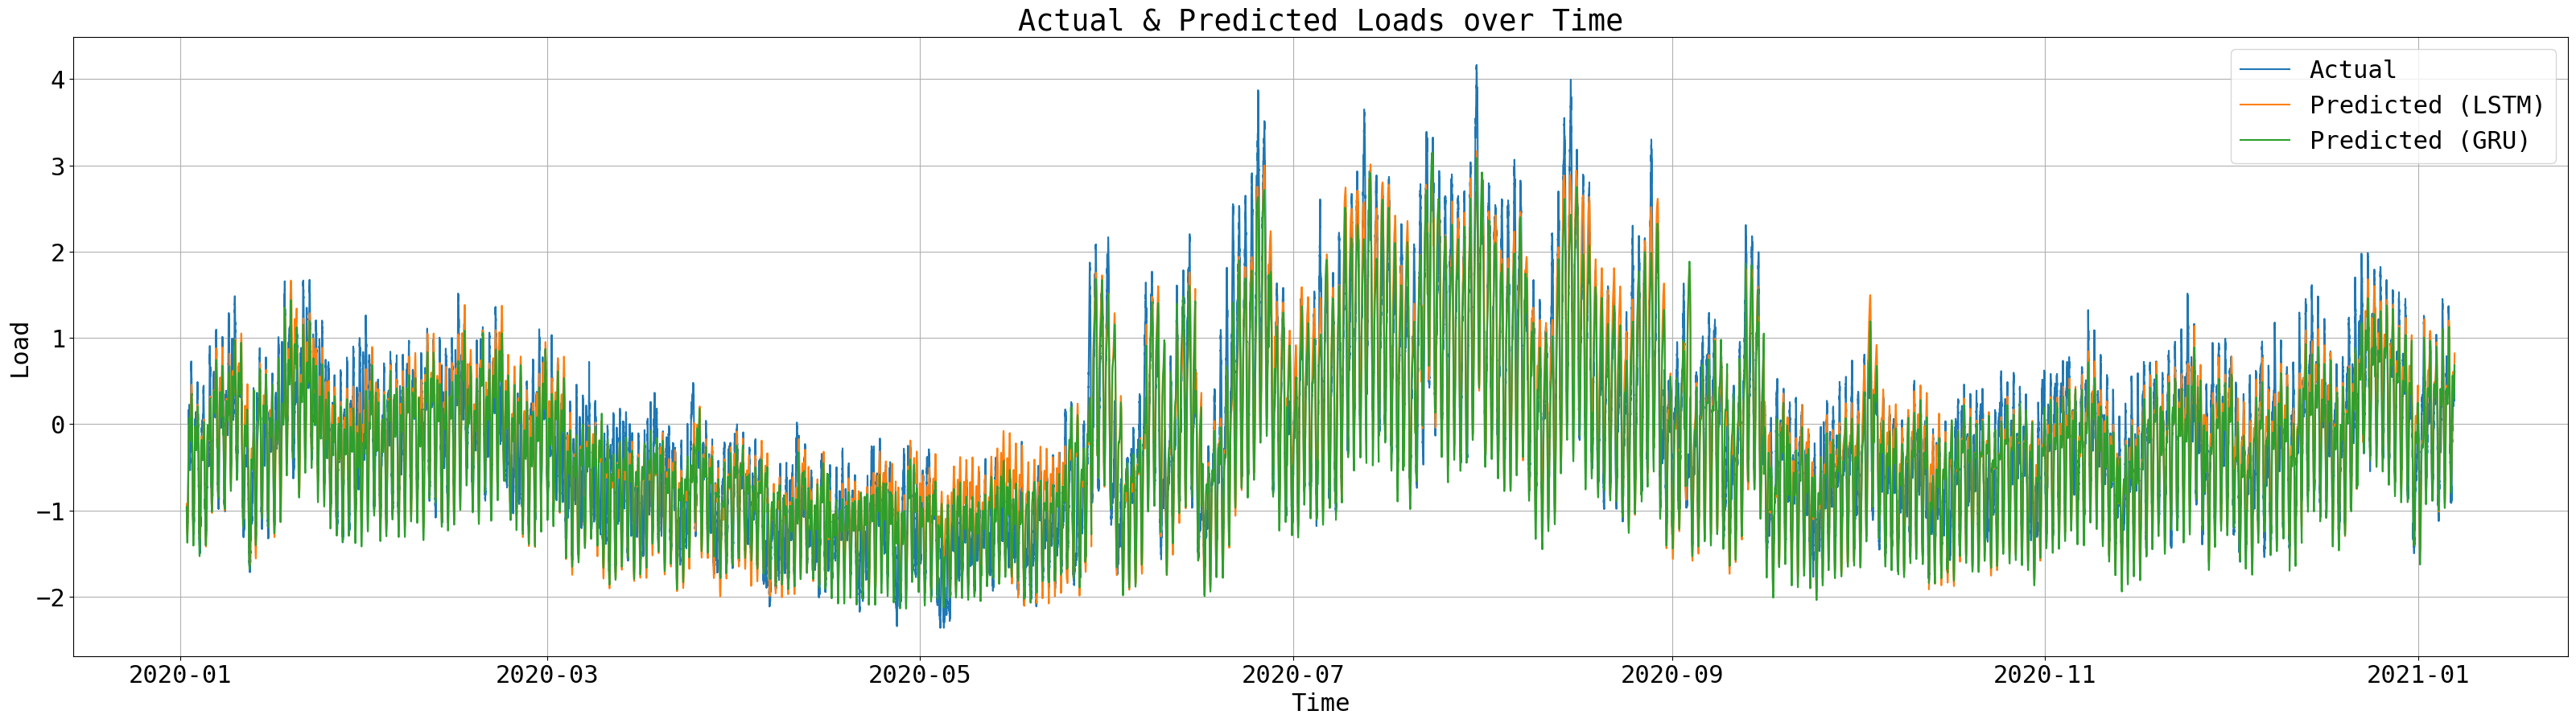

In [24]:
# rnn_scores = evaluate_metrics(actual, predictions_rnn)
# print(f'RNN: MAE {rnn_scores[0]}, MAPE {rnn_scores[1]}, R^2 {rnn_scores[2]}')
lstm_scores = evaluate_metrics(actual, predictions_lstm)
print(f'LSTM: MAE {lstm_scores[0]}, MAPE {lstm_scores[1]}, R^2 {lstm_scores[2]}')
gru_scores = evaluate_metrics(actual, predictions_gru)
print(f'GRU: MAE {gru_scores[0]}, MAPE {gru_scores[1]}, R^2 {gru_scores[2]}')

font = {'family' : 'monospace',
        'weight' : 'normal',
        'size'   : 22}

plt.rc('font', **font)

time_interval = pd.date_range(start="2020-01-02", periods=len(actual), freq='5min')
plt.figure(figsize=(40,10))
plt.plot(time_interval, actual, label='Actual')
# plt.plot(time_interval, predictions_rnn, label='Predicted (RNN)')
plt.plot(time_interval, predictions_lstm, label='Predicted (LSTM)')
plt.plot(time_interval, predictions_gru, label='Predicted (GRU)')
plt.legend()
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Load')
plt.title('Actual & Predicted Loads over Time')
plt.show()